# STAT 6289 Deep Learning Midterm Project

In [1]:
import os
from random import seed, random
from shutil import copyfile
from os import listdir
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [27]:
# Separate data into training, validation and test
data_dir = '/users/yipengwei/Desktop/Deep Learning 6289/Midterm Project/dogs vs cats/data/'
working_dir = '/users/yipengwei/Desktop/Deep Learning 6289/Midterm Project/dogs vs cats/working/'

# seed random number generator
seed(666)
# define ratio of pictures to use for validation and test
val_ratio = 0.4
test_ratio = 0.2

# Ensure the target directories exist
os.makedirs('/users/yipengwei/Desktop/Deep Learning 6289/Midterm Project/dogs vs cats/working/train/', exist_ok=True)
os.makedirs('/users/yipengwei/Desktop/Deep Learning 6289/Midterm Project/dogs vs cats/working/val/', exist_ok=True)
os.makedirs('/users/yipengwei/Desktop/Deep Learning 6289/Midterm Project/dogs vs cats/working/test/', exist_ok=True)

for file in listdir(data_dir):
    r = random()  # generate random number once per file
    file_dir = data_dir + file

    if r > val_ratio:
        split = 'train/'
    elif (r <= val_ratio) & (r > test_ratio):
        split = 'val/'
    else:
        split = 'test/'

    final_dir = working_dir + split + file
    copyfile(file_dir, final_dir)

train_dir = working_dir + "train"
val_dir = working_dir + "val"
test_dir = working_dir + "test"

print('The number of images in training data is', len(os.listdir(train_dir)))
print('The number of images in validation data is', len(os.listdir(val_dir)))
print('The number of images in test data is', len(os.listdir(test_dir)))


The number of images in training data is 14969
The number of images in validation data is 4981
The number of images in test data is 5050


In [3]:
#training data
x_train_filenames = os.listdir(train_dir)
x_train_labels = [x.split(".")[0] for x in x_train_filenames]

x_train = pd.DataFrame({"filename": x_train_filenames, "label": x_train_labels})

#validation data
x_val_filenames = os.listdir(val_dir)
x_val_labels = [x.split(".")[0] for x in x_val_filenames]

x_val = pd.DataFrame({"filename": x_val_filenames, "label": x_val_labels})

#test data
x_test_filenames = os.listdir(test_dir)
x_test_labels = [x.split(".")[0] for x in x_test_filenames]

x_test = pd.DataFrame({"filename": x_test_filenames, "label": x_test_labels})

In [4]:
# parameters
image_size = 128
image_channel = 3
bat_size = 64

# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying image data gernerator to training, validation data and test data

train_generator = train_datagen.flow_from_dataframe(x_train,
                                                    directory = train_dir ,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = val_datagen.flow_from_dataframe(x_val, 
                                                 directory = val_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(x_test, 
                                                 directory = test_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )


Found 14969 validated image filenames belonging to 2 classes.
Found 4981 validated image filenames belonging to 2 classes.
Found 5050 validated image filenames belonging to 2 classes.


In [5]:
#CNN model 1
modelCNN1 = Sequential()

# Input Layer
modelCNN1.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
modelCNN1.add(BatchNormalization())
modelCNN1.add(MaxPooling2D(pool_size=(2,2)))
modelCNN1.add(Dropout(0.5))

# Block 1 
modelCNN1.add(Conv2D(64,(3,3),activation='relu'))
modelCNN1.add(BatchNormalization())
modelCNN1.add(MaxPooling2D(pool_size=(2,2)))
modelCNN1.add(Dropout(0.5))

# Fully Connected layers 
modelCNN1.add(Flatten())
modelCNN1.add(Dense(512,activation='relu'))
modelCNN1.add(BatchNormalization())
modelCNN1.add(Dropout(0.5))

# Output layer
modelCNN1.add(Dense(2,activation='softmax'))

modelCNN1.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

modelCNN1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

dog_vs_cat_CNN1 = modelCNN1.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 50
                   )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

234/234 [==============================] - 61s 258ms/step - loss: 0.4179 - accuracy: 0.8097 - val_loss: 5.4630 - val_accuracy: 0.7252 - lr: 1.0000e-05
Epoch 30/50
234/234 [==============================] - 61s 262ms/step - loss: 0.4145 - accuracy: 0.8103 - val_loss: 6.1828 - val_accuracy: 0.7233 - lr: 1.0000e-05
Epoch 31/50
234/234 [==============================] - 61s 261ms/step - loss: 0.4207 - accuracy: 0.8066 - val_loss: 5.9178 - val_accuracy: 0.7244 - lr: 1.0000e-05
Epoch 32/50
234/234 [==============================] - 60s 255ms/step - loss: 0.4203 - accuracy: 0.8040 - val_loss: 5.6705 - val_accuracy: 0.7290 - lr: 1.0000e-05
Epoch 33/50
234/234 [==============================] - 59s 253ms/step - loss: 0.4149 - accuracy: 0.8047 - val_loss: 5.7408 - val_accuracy: 0.7233 - lr: 1.0000e-05
Epoch 34/50
234/234 [==============================] - 60s 256ms/step - loss: 0.4205 - accuracy: 0.8053 - val_loss: 5.8203 - val_accuracy: 0.7225 - lr: 1.0000e-05
Epoch 35/50
234/234 [=============

In [6]:
#CNN model 2
modelCNN2 = Sequential()

# Input Layer
modelCNN2.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
modelCNN2.add(BatchNormalization())
modelCNN2.add(MaxPooling2D(pool_size=(2,2)))
modelCNN2.add(Dropout(0.5))

# Block 1 
modelCNN2.add(Conv2D(64,(3,3),activation='relu'))
modelCNN2.add(BatchNormalization())
modelCNN2.add(MaxPooling2D(pool_size=(2,2)))
modelCNN2.add(Dropout(0.5))

# Block 2 
modelCNN2.add(Conv2D(128,(3,3),activation='relu'))
modelCNN2.add(BatchNormalization())
modelCNN2.add(MaxPooling2D(pool_size=(2,2)))
modelCNN2.add(Dropout(0.5))

# Block 3 
modelCNN2.add(Conv2D(256,(3,3),activation='relu'))
modelCNN2.add(BatchNormalization())
modelCNN2.add(MaxPooling2D(pool_size=(2,2)))
modelCNN2.add(Dropout(0.5))

# Fully Connected layers 
modelCNN2.add(Flatten())
modelCNN2.add(Dense(512,activation='relu'))
modelCNN2.add(BatchNormalization())
modelCNN2.add(Dropout(0.5))

# Output layer
modelCNN2.add(Dense(2,activation='softmax'))

modelCNN2.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

modelCNN2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

dog_vs_cat_CNN2 = modelCNN2.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 50
                   )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 61, 64)       

234/234 [==============================] - 77s 330ms/step - loss: 0.3679 - accuracy: 0.8339 - val_loss: 0.9082 - val_accuracy: 0.7111 - lr: 1.0000e-05
Epoch 22/50
234/234 [==============================] - 76s 322ms/step - loss: 0.3742 - accuracy: 0.8351 - val_loss: 0.9786 - val_accuracy: 0.6987 - lr: 1.0000e-05
Epoch 23/50
234/234 [==============================] - 74s 315ms/step - loss: 0.3637 - accuracy: 0.8345 - val_loss: 0.9254 - val_accuracy: 0.7085 - lr: 1.0000e-05
Epoch 24/50
234/234 [==============================] - 78s 333ms/step - loss: 0.3677 - accuracy: 0.8365 - val_loss: 0.9534 - val_accuracy: 0.7047 - lr: 1.0000e-05
Epoch 25/50
234/234 [==============================] - 76s 322ms/step - loss: 0.3653 - accuracy: 0.8346 - val_loss: 0.9845 - val_accuracy: 0.6956 - lr: 1.0000e-05
Epoch 26/50
234/234 [==============================] - 76s 324ms/step - loss: 0.3695 - accuracy: 0.8351 - val_loss: 0.9280 - val_accuracy: 0.7075 - lr: 1.0000e-05
Epoch 27/50
234/234 [=============

In [7]:
#CNN model 3
modelCNN3 = Sequential()

# Input Layer
modelCNN3.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
modelCNN3.add(BatchNormalization())
modelCNN3.add(MaxPooling2D(pool_size=(2,2)))
modelCNN3.add(Dropout(0.2))

# Block 1 
modelCNN3.add(Conv2D(64,(3,3),activation='relu'))
modelCNN3.add(BatchNormalization())
modelCNN3.add(MaxPooling2D(pool_size=(2,2)))
modelCNN3.add(Dropout(0.2))

# Block 2 
modelCNN3.add(Conv2D(128,(3,3),activation='relu'))
modelCNN3.add(BatchNormalization())
modelCNN3.add(MaxPooling2D(pool_size=(2,2)))
modelCNN3.add(Dropout(0.2))

# Block 3 
modelCNN3.add(Conv2D(256,(3,3),activation='relu'))
modelCNN3.add(BatchNormalization())
modelCNN3.add(MaxPooling2D(pool_size=(2,2)))
modelCNN3.add(Dropout(0.2))

# Fully Connected layers 
modelCNN3.add(Flatten())
modelCNN3.add(Dense(512,activation='relu'))
modelCNN3.add(BatchNormalization())
modelCNN3.add(Dropout(0.2))

# Output layer
modelCNN3.add(Dense(2,activation='softmax'))

modelCNN3.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

modelCNN3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

dog_vs_cat_CNN3 = modelCNN3.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 50
                   )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)       

234/234 [==============================] - 73s 312ms/step - loss: 0.1544 - accuracy: 0.9370 - val_loss: 0.1656 - val_accuracy: 0.9309 - lr: 6.2500e-05
Epoch 25/50
234/234 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9361
Epoch 25: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
234/234 [==============================] - 74s 317ms/step - loss: 0.1581 - accuracy: 0.9361 - val_loss: 0.1621 - val_accuracy: 0.9341 - lr: 6.2500e-05
Epoch 26/50
234/234 [==============================] - 76s 322ms/step - loss: 0.1513 - accuracy: 0.9388 - val_loss: 0.1667 - val_accuracy: 0.9329 - lr: 3.1250e-05
Epoch 27/50
234/234 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9415
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
234/234 [==============================] - 75s 319ms/step - loss: 0.1462 - accuracy: 0.9415 - val_loss: 0.1657 - val_accuracy: 0.9311 - lr: 3.1250e-05
Epoch 28/50
234/234 [==============

In [8]:
#DNN model 1
modelDNN1 = Sequential()

# Input Layer: Flatten layer to reshape the input
modelDNN1.add(Flatten(input_shape=(image_size, image_size, image_channel)))

# Dense Layer 1
modelDNN1.add(Dense(32, activation='relu'))
modelDNN1.add(BatchNormalization())
modelDNN1.add(Dropout(0.5))

# Dense Layer 2
modelDNN1.add(Dense(64, activation='relu'))
modelDNN1.add(BatchNormalization())
modelDNN1.add(Dropout(0.5))

# Dense Layer 3
modelDNN1.add(Dense(512, activation='relu'))
modelDNN1.add(BatchNormalization())
modelDNN1.add(Dropout(0.5))

# Output layer
modelDNN1.add(Dense(2, activation='sigmoid')) 

modelDNN1.summary()

modelDNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dog_vs_cat_DNN1 = modelDNN1.fit(train_generator,
                    validation_data=val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs=50
                   )


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                1572896   
                                                                 
 batch_normalization_13 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_14 (Ba  (None, 64)                256       
 tchNormalization)                                    

Epoch 32/50
234/234 [==============================] - 43s 185ms/step - loss: 0.6603 - accuracy: 0.5994 - val_loss: 0.6569 - val_accuracy: 0.6077 - lr: 1.0000e-05
Epoch 33/50
234/234 [==============================] - 44s 186ms/step - loss: 0.6586 - accuracy: 0.6106 - val_loss: 0.6532 - val_accuracy: 0.6145 - lr: 1.0000e-05
Epoch 34/50
234/234 [==============================] - 44s 187ms/step - loss: 0.6608 - accuracy: 0.6040 - val_loss: 0.6545 - val_accuracy: 0.6127 - lr: 1.0000e-05
Epoch 35/50
234/234 [==============================] - 43s 185ms/step - loss: 0.6600 - accuracy: 0.6042 - val_loss: 0.6535 - val_accuracy: 0.6153 - lr: 1.0000e-05
Epoch 36/50
234/234 [==============================] - 43s 185ms/step - loss: 0.6606 - accuracy: 0.6029 - val_loss: 0.6544 - val_accuracy: 0.6133 - lr: 1.0000e-05
Epoch 37/50
234/234 [==============================] - 44s 187ms/step - loss: 0.6605 - accuracy: 0.6061 - val_loss: 0.6567 - val_accuracy: 0.6107 - lr: 1.0000e-05
Epoch 38/50
234/234 [=

In [9]:
#DNN model 2
modelDNN2 = Sequential()

# Input Layer: Flatten layer to reshape the input
modelDNN2.add(Flatten(input_shape=(image_size, image_size, image_channel)))

# Dense Layer 1
modelDNN2.add(Dense(32, activation='relu'))
modelDNN2.add(BatchNormalization())
modelDNN2.add(Dropout(0.5))

# Dense Layer 2
modelDNN2.add(Dense(64, activation='relu'))
modelDNN2.add(BatchNormalization())
modelDNN2.add(Dropout(0.5))

# Dense Layer 3
modelDNN2.add(Dense(128, activation='relu'))
modelDNN2.add(BatchNormalization())
modelDNN2.add(Dropout(0.5))

# Dense Layer 4
modelDNN2.add(Dense(256, activation='relu'))
modelDNN2.add(BatchNormalization())
modelDNN2.add(Dropout(0.5))

# Dense Layer 5
modelDNN2.add(Dense(512, activation='relu'))
modelDNN2.add(BatchNormalization())
modelDNN2.add(Dropout(0.5))

# Output layer
modelDNN2.add(Dense(2, activation='sigmoid')) 

modelDNN2.summary()

modelDNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dog_vs_cat_DNN2 = modelDNN2.fit(train_generator,
                    validation_data=val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs=50
                   )


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 49152)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                1572896   
                                                                 
 batch_normalization_16 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_17 (Ba  (None, 64)                256       
 tchNormalization)                                    

Epoch 26/50
234/234 [==============================] - 44s 190ms/step - loss: 0.6682 - accuracy: 0.5924 - val_loss: 0.6790 - val_accuracy: 0.5808 - lr: 1.0000e-05
Epoch 27/50
234/234 [==============================] - 44s 190ms/step - loss: 0.6662 - accuracy: 0.6013 - val_loss: 0.6802 - val_accuracy: 0.5770 - lr: 1.0000e-05
Epoch 28/50
234/234 [==============================] - 45s 190ms/step - loss: 0.6672 - accuracy: 0.5989 - val_loss: 0.6806 - val_accuracy: 0.5764 - lr: 1.0000e-05
Epoch 29/50
234/234 [==============================] - 44s 190ms/step - loss: 0.6683 - accuracy: 0.5940 - val_loss: 0.6802 - val_accuracy: 0.5792 - lr: 1.0000e-05
Epoch 30/50
234/234 [==============================] - 45s 191ms/step - loss: 0.6707 - accuracy: 0.5903 - val_loss: 0.6802 - val_accuracy: 0.5776 - lr: 1.0000e-05
Epoch 31/50
234/234 [==============================] - 45s 190ms/step - loss: 0.6702 - accuracy: 0.5894 - val_loss: 0.6792 - val_accuracy: 0.5780 - lr: 1.0000e-05
Epoch 32/50
234/234 [=

In [10]:
#DNN model 3
modelDNN3 = Sequential()

# Input Layer: Flatten layer to reshape the input
modelDNN3.add(Flatten(input_shape=(image_size, image_size, image_channel)))

# Dense Layer 1
modelDNN3.add(Dense(32, activation='relu'))
modelDNN3.add(BatchNormalization())
modelDNN3.add(Dropout(0.2))

# Dense Layer 2
modelDNN3.add(Dense(64, activation='relu'))
modelDNN3.add(BatchNormalization())
modelDNN3.add(Dropout(0.2))

# Dense Layer 3
modelDNN3.add(Dense(128, activation='relu'))
modelDNN3.add(BatchNormalization())
modelDNN3.add(Dropout(0.2))

# Dense Layer 4
modelDNN3.add(Dense(256, activation='relu'))
modelDNN3.add(BatchNormalization())
modelDNN3.add(Dropout(0.2))

# Dense Layer 5
modelDNN3.add(Dense(512, activation='relu'))
modelDNN3.add(BatchNormalization())
modelDNN3.add(Dropout(0.2))

# Output layer
modelDNN3.add(Dense(2, activation='sigmoid')) 

modelDNN3.summary()

modelDNN3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dog_vs_cat_DNN3 = modelDNN3.fit(train_generator,
                    validation_data=val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs=50
                   )


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 49152)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                1572896   
                                                                 
 batch_normalization_21 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_22 (Ba  (None, 64)                256       
 tchNormalization)                                    

234/234 [==============================] - 44s 188ms/step - loss: 0.6451 - accuracy: 0.6203 - val_loss: 0.6196 - val_accuracy: 0.6495 - lr: 1.0000e-05
Epoch 27/50
234/234 [==============================] - 44s 189ms/step - loss: 0.6435 - accuracy: 0.6209 - val_loss: 0.6197 - val_accuracy: 0.6489 - lr: 1.0000e-05
Epoch 28/50
234/234 [==============================] - 44s 188ms/step - loss: 0.6434 - accuracy: 0.6267 - val_loss: 0.6194 - val_accuracy: 0.6477 - lr: 1.0000e-05
Epoch 29/50
234/234 [==============================] - 44s 189ms/step - loss: 0.6417 - accuracy: 0.6254 - val_loss: 0.6177 - val_accuracy: 0.6515 - lr: 1.0000e-05
Epoch 30/50
234/234 [==============================] - 44s 189ms/step - loss: 0.6395 - accuracy: 0.6292 - val_loss: 0.6188 - val_accuracy: 0.6509 - lr: 1.0000e-05
Epoch 31/50
234/234 [==============================] - 44s 189ms/step - loss: 0.6436 - accuracy: 0.6216 - val_loss: 0.6185 - val_accuracy: 0.6515 - lr: 1.0000e-05
Epoch 32/50
234/234 [=============

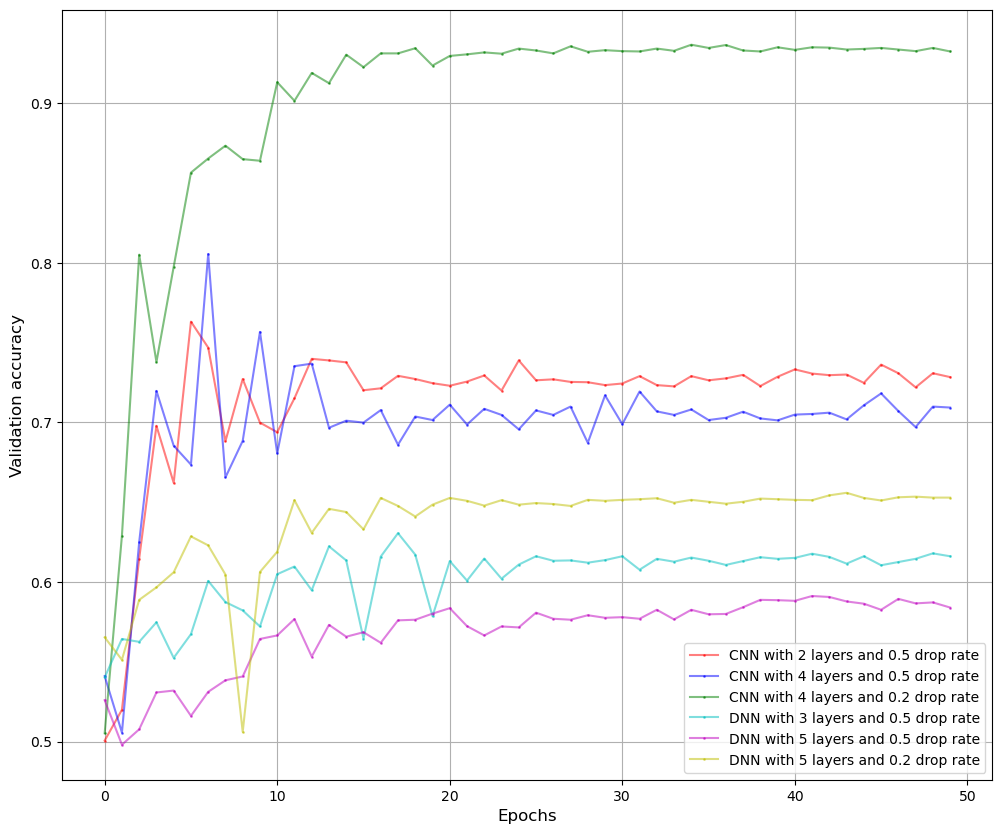

In [18]:
#Validation accuracy plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.grid() 
plt.plot(range(50),dog_vs_cat_CNN1.history['val_accuracy'],'-or',alpha=0.5,label='CNN with 2 layers and 0.5 drop rate',markersize=1) 
plt.plot(range(50),dog_vs_cat_CNN2.history['val_accuracy'],'-ob',alpha=0.5,label='CNN with 4 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_CNN3.history['val_accuracy'],'-og',alpha=0.5,label='CNN with 4 layers and 0.2 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN1.history['val_accuracy'],'-oc',alpha=0.5,label='DNN with 3 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN2.history['val_accuracy'],'-om',alpha=0.5,label='DNN with 5 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN3.history['val_accuracy'],'-oy',alpha=0.5,label='DNN with 5 layers and 0.2 drop rate',markersize=1)

plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Validation accuracy',fontsize=12)
_=plt.legend(loc='best')


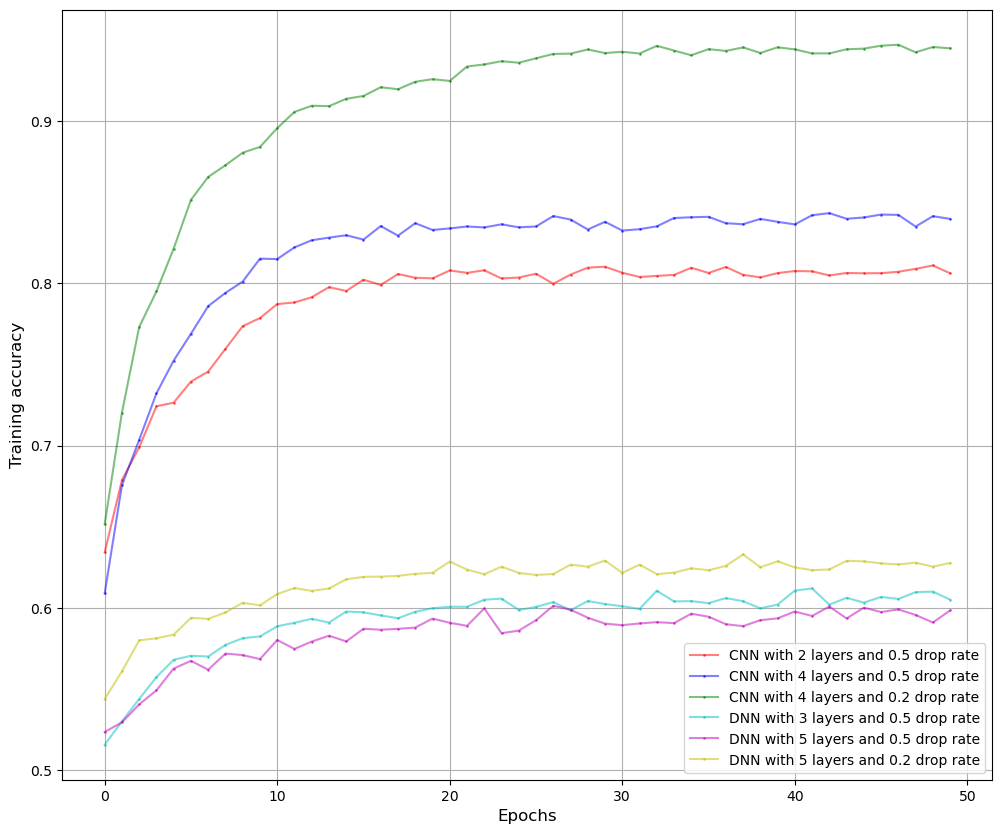

In [19]:
#Training accuracy plot
plt.figure(figsize=(12, 10))

plt.grid() 
plt.plot(range(50),dog_vs_cat_CNN1.history['accuracy'],'-or',alpha=0.5,label='CNN with 2 layers and 0.5 drop rate',markersize=1) 
plt.plot(range(50),dog_vs_cat_CNN2.history['accuracy'],'-ob',alpha=0.5,label='CNN with 4 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_CNN3.history['accuracy'],'-og',alpha=0.5,label='CNN with 4 layers and 0.2 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN1.history['accuracy'],'-oc',alpha=0.5,label='DNN with 3 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN2.history['accuracy'],'-om',alpha=0.5,label='DNN with 5 layers and 0.5 drop rate',markersize=1)
plt.plot(range(50),dog_vs_cat_DNN3.history['accuracy'],'-oy',alpha=0.5,label='DNN with 5 layers and 0.2 drop rate',markersize=1)

plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Training accuracy',fontsize=12)
_=plt.legend(loc='best')

In [24]:
#Accuracy on test data
scores1 = modelCNN1.evaluate(test_generator, verbose=1)
scores2 = modelCNN2.evaluate(test_generator, verbose=1)
scores3 = modelCNN3.evaluate(test_generator, verbose=1)
scores4 = modelDNN1.evaluate(test_generator, verbose=1)
scores5 = modelDNN2.evaluate(test_generator, verbose=1)
scores6 = modelDNN3.evaluate(test_generator, verbose=1)

models = ['CNN with 2 layers and 0.5 drop rate', 'CNN with 4 layers and 0.5 drop rate', 'CNN with 4 layers and 0.2 drop rate', 'DNN with 3 layers and 0.5 drop rate', 'DNN with 5 layers and 0.5 drop rate', 'DNN with 5 layers and 0.2 drop rate']
scores = [scores1, scores2, scores3, scores4, scores5, scores6]

accuracy_values = [s[1] for s in scores]

df = pd.DataFrame(accuracy_values, columns=['Accuracy'], index=models)
print(df)

79/79 [==============================] - 6s 72ms/step - loss: 0.6287 - accuracy: 0.6424
                                     Accuracy
CNN with 2 layers and 0.5 drop rate  0.717822
CNN with 4 layers and 0.5 drop rate  0.688515
CNN with 4 layers and 0.2 drop rate  0.934455
DNN with 3 layers and 0.5 drop rate  0.607723
DNN with 5 layers and 0.5 drop rate  0.586535
DNN with 5 layers and 0.2 drop rate  0.642376


In [25]:
#Prediction and confusion matrix
pred = modelCNN3.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(pred, axis = 1)
y_true = test_generator.labels

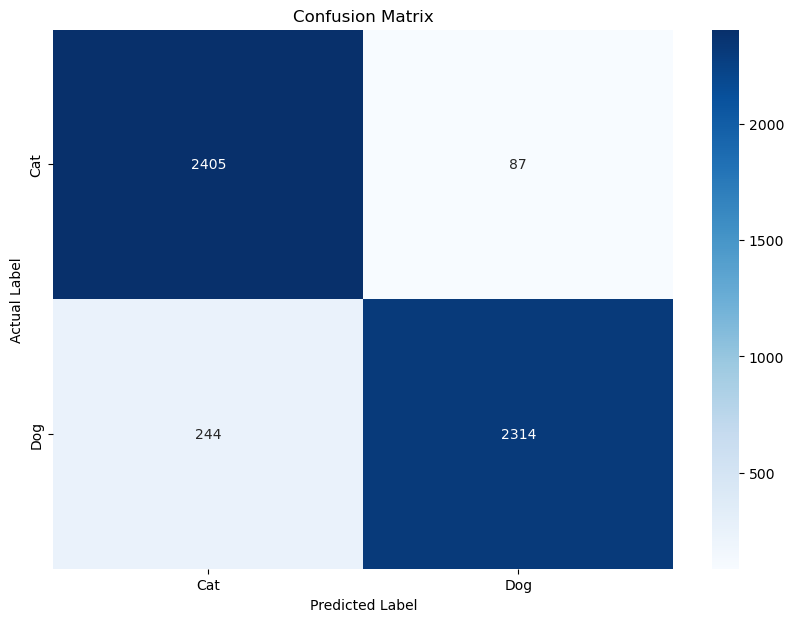

In [26]:
result_confusion_matrix=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(result_confusion_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()